<a href="https://colab.research.google.com/github/Mikhail-Repin/Rec_sys_Tinkoff_enr_test/blob/main/hw1_recsys_Repin_Mikhail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: ---**

**Дедлайн: --- MSK**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
#from metric_tests import run_tests

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/interactions.csv').iloc[:-1]
print(df.last_watch_dt.min())
df.head()

2021-03-13


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
4708105,777569,6382,108,464,0.0
30640,1079399,2447,10,2457,53.0
1672435,1007387,14488,158,684,11.0
196186,87998,9035,109,7525,100.0
3726148,412158,3935,160,387,7.0


Сделаем разбиение по времени

<Axes: >

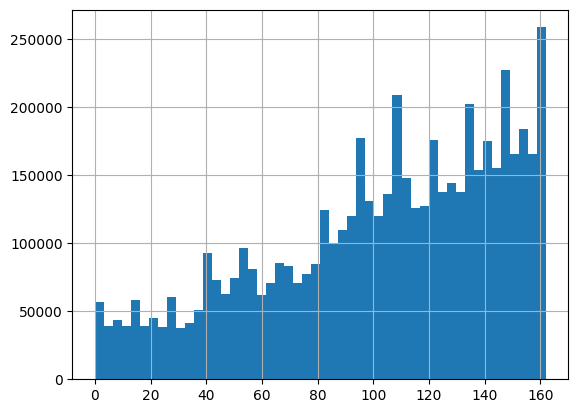

In [ ]:
df.last_watch_dt.hist(bins=50)

In [ ]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('train_users:', train_users.shape[0])
print('test_users:', test_users.shape[0])
print('всего: ', len(set(train_users) | set(test_users)))

число людей и там и там:  134670
train_users: 880449
test_users: 216400
всего:  962179


In [ ]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету

In [ ]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [ ]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
27,841859,3935,94,8862,100.0
56,580093,15411,151,10479,100.0
150,179618,9988,121,6811,100.0
227,84682,4209,141,7399,99.0
234,20224,8650,102,154,3.0


In [ ]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,119,"[(9728, 134), (4436, 135)]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399..."
3,522,"[(12501, 14), (2424, 15), (12254, 15), (6222, ..."
4,552,"[(10440, 147)]"


In [ ]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]"
3,522,"[(12501, 14), (2424, 15), (12254, 15), (6222, ...","[(11756, 155), (4201, 159), (11899, 159), (107..."
4,552,"[(10440, 147)]","[(14703, 158)]"


In [ ]:
np.random.seed(27)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[6259, 9287, 14491]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[6259, 9287, 14491]"
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[6259, 9287, 14491]"
3,522,"[(12501, 14), (2424, 15), (12254, 15), (6222, ...","[(11756, 155), (4201, 159), (11899, 159), (107...","[6259, 9287, 14491]"
4,552,"[(10440, 147)]","[(14703, 158)]","[6259, 9287, 14491]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$

In [ ]:
def relevance(true_items: List[int],
              items: List[int]):
  zeros = set(items) - set(true_items)
  res = []
  for x in items:
    if x in zeros:
      res.append(0)
    else:
      res.append(1)
  return np.array(res)


def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
# everything's vectorized :)
    if len(predictions) == 0:
      return 0
    if topn is None:
      topn = len(gt_items)
    k = len(predictions)
    relevant = relevance(gt_items[:topn], predictions)
    tmp = 1/np.sum(np.tri(k, k), 1)
    Summator = np.tri(k, k)
    pr = tmp*(np.matmul(Summator, relevant))
    return np.sum(relevant*pr)/(min(k, len(gt_items)))

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if len(predictions) == 0:
      return 0
    if topn is None:
      topn = len(gt_items)
    k = len(predictions)
    relevant = relevance(gt_items[:topn], predictions)
    res = np.argmax(relevant)
    if relevant[res] == 0:
      res = 0
    else:
      res = 1/(res+1)
    return res

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if len(predictions) == 0:
      return 0
    if topn is None:
      topn = len(gt_items)
    k = len(predictions)
    relevant = relevance(gt_items[:topn], predictions)
    return max(relevant)

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить из не стоит, разумеется

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать

In [ ]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое

In [ ]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.00017777777777777779, 'mrr': 0.0002666666666666666, 'hr': 0.0006}

In [ ]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommendations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=100)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommendations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,ease_preds
0,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[13865, 10440, 9728, 3734, 10772, 8636, 6809, ..."
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 9728, 13865, 12995, 3734, 7102, 4151, ..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 13865, 9996, 3734, 512, 1..."
3,522,"[(12501, 14), (2424, 15), (12254, 15), (6222, ...","[(11756, 155), (4201, 159), (11899, 159), (107...","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 4151, 9728, 10440, 4880, 1844, 6253, 3..."
4,552,"[(10440, 147)]","[(14703, 158)]","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 13865, 9728, 2657, 9996, 142, 4151, 12..."


Самые популярные предсказания должны дать сильно получше

In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06829414758125472, 'mrr': 0.1214040476190476, 'hr': 0.2764}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что вне его пределов, учитывать не надо

In [ ]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, day in row[col]:
              if day <= self.min_window:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1
        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommendations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommendations[:topn]]*len(df)

In [ ]:
toppopwind = TopPopularWeighted(200)
toppopwind.fit(joined)
joined['toppopular_recs_min_wind'] = toppopwind.predict(joined)
evaluate_recommender(joined, model_preds='toppopular_recs_min_wind')

{'map': 0.06829414758125472, 'mrr': 0.1214040476190476, 'hr': 0.2764}

Теперь постройте графики зависимости трёх метрик от размера окна

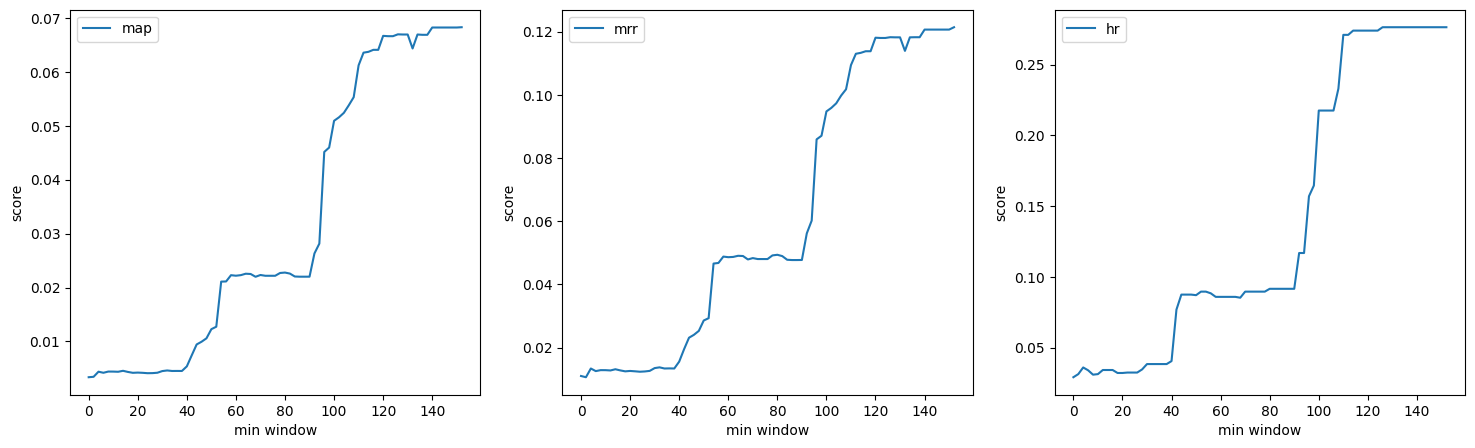

In [ ]:
days = joined.train_interactions.apply(lambda x: max([i[1] for i in x]))

# можно добавить в arange значение для step, чтобы побыстрее отработало, например для step = 5 работает за 1 минуту
x = np.arange(min(days), max(days)+1, 2)
y = []
for wind in x:
  toppopwind = TopPopularWeighted(wind)
  toppopwind.fit(joined)
  joined['toppopular_recs_min_wind'] = toppopwind.predict(joined)
  y.append([res[1] for res in evaluate_recommender(joined, model_preds='toppopular_recs_min_wind').items()])
y = np.array(y)

names = ["map", "mrr", "hr"]
plt.figure(figsize=(18,5))
for i, name in enumerate(names):
  plt.subplot(131+i)
  plt.plot(x, y[:, i], label = name)
  plt.xlabel("min window")
  plt.ylabel("score")
  plt.legend()
plt.show()

Подумайте и ответьте, как окно влияет на качество. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** Из графиков видно, что метрики ведут себя одинаково с увеличением окна. При чем, когда окно мленькое, то значения метрик остаютя на низаком уровне и почти не меняются из-за того, что наиболее популярные фильмы в такое маленькое окно мало связаны с теми фильмами, которые пользователи смотрели недавно (в тестовой выборке). Затем графики имеют ступенчатый рост и выходят на новое плато. Это объясняется также: с таким окном фильмы тестовой выборки имеют чуть больший вес, чем раньше и больше из них могут попасть в предсказания. И наконец, когда окно становится таким, что мы перебираем почти все фильмы из тренировочный выборки, качество снова резко возрастает: еще больше фильмов из тестовой выборки попадают в рассматриваемое окно. Таким образом в данной задаче для данного алгоритма лучше всего рассматривать всю тренировочную выборку без окна.

**Задание №3. Метрики и k.**

Постройте зависимости MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на графике

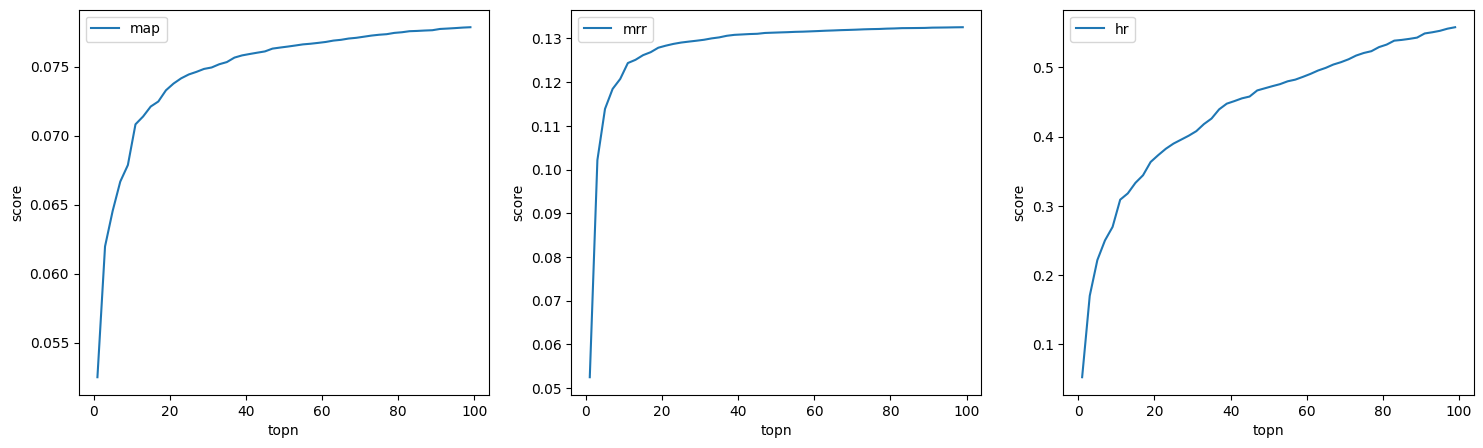

In [ ]:
x = np.arange(1, 100, 2)
y = []
toppop = TopPopular()
toppop.fit(joined)
for n in x:
  joined['toppopular_recs'] = toppop.predict(joined, topn = n)
  y.append([res[1] for res in evaluate_recommender(joined, model_preds='toppopular_recs').items()])
y = np.array(y)

names = ["map", "mrr", "hr"]
plt.figure(figsize=(18,5))
for i, name in enumerate(names):
  plt.subplot(131+i)
  plt.plot(x, y[:, i], label = name)
  plt.xlabel("topn")
  plt.ylabel("score")
  plt.legend()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** Как видно из графиков, все метрики монотонно возрастают по top-K. Вид этих графиков тоже ясен: \
для `map`: число релевантных айтемов с увеличением top-K может только увеличиться, поэтому число ненулевых слагаемых в сумме только возрастает -> растет сама сумма, однако важным является вопрос деления перед суммой: если бы мы делили на на длину всего вектора предсказаний, а не на число айтемов пользователя, то значение метрики бы падало;\
для `mrr`: понятно, что для конкретного юзера после того, как удалось захватить в предсказания хотя бы 1 релевантный айтем, значение должно оставаться постоянным (с увеличением top-K мы конечно можем и еще больше угадывать релевантных айтемов, однако их позиция будет дальше), однако все таки график этой метрики резко растет в начале, это связано с усреднением - с увеличением top-K мы для большего числа юзеров даем хотя бы 1 релевантный айтем;\
для `hr`: все объяснено в предыдущем предложении - с увеличением top-K мы для большего числа юзеров даем хотя бы 1 релевантный айтем, отличия от почти константного графика `mrr` в том, что каждый новый юзер, для которого мы предсказали релевантный айтем, дает равномерный вкалд в сумму (+1), которую мы осредняем.

Объясните по каждой метрике, как можно интерпретировать ее график? То есть что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например скроллингом ленты новостей. \
**Ответ:** Большинство стриминговых сервисов предлагают пользователю что посмотреть: это могут быть рекомендации как на основе его интересов, так и просто самые популярные фильмы/сериалы за месяц. Кроме того, если юзер новый, то его рекомендации могут состоять как раз в основном из самых популярных среди всех (иногда на основе тех жанров, которые он мог отметить при регистрации). Таким образом, чем больше мы берем top-K, тем больше мы угадываем тех айтемов, котрые реально были предложены на стриминговом сервисе пользователям. В случае с `mrr` и `hr`, как сказано выше, после хотя бы одного угаданного айтема значением метрики для конкретного юзера меняться уже не будет. А вот для `map` мы не только увеличиваем число ненулевых значений метрик по разным юзерам, а еще и для каждого пользователя больше угадываем фильмов, котрые скорее всего он посмотрел, благодаря рекомендациям сервиса.

Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Может помочь поанализировать данные)\
**Ответ:** Объяснение роста графиков и характера их роста уже есть в первом пункте.

**Задание №4. Интерпретация рейтингов**

Теперь возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения попуряности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей

In [ ]:
items = pd.read_csv('/content/drive/MyDrive/items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

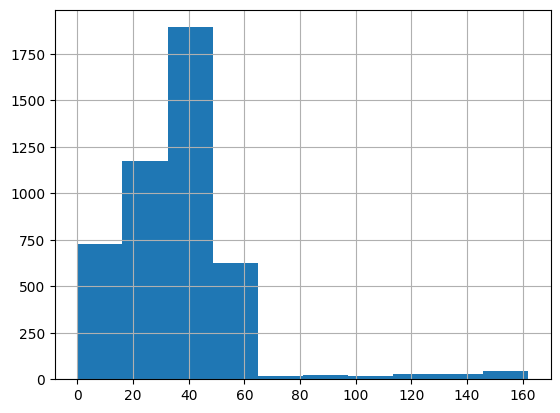

In [ ]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 был набирал популярность какое-то время, потом видим резкое падение (с какой даты, кстати?). Возможно связано с ограничением доступности к этому фильму, однако не всем участникам, либо же это период проката фильмы / рекламной кампании, и т.д.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали\
Я искал данные, изучая колонки, которые есть в датасете `items`. Проверял различные гипотезы про просмотры фильмов, объединенных той или иной категорией. Кроме того, некторые паттерны помогло найти изучение платформы **Kion** и их оригинальных продуктов, это дало понимание, на какизх примерах можно увидеть результаты рекомендаций сервиса.

In [ ]:
items = pd.read_csv('/content/drive/MyDrive/items.csv').copy()
print(set(items.content_type.tolist()))
items.head()

{'film', 'series'}


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


<Axes: title={'center': 'Российские сериалы'}>

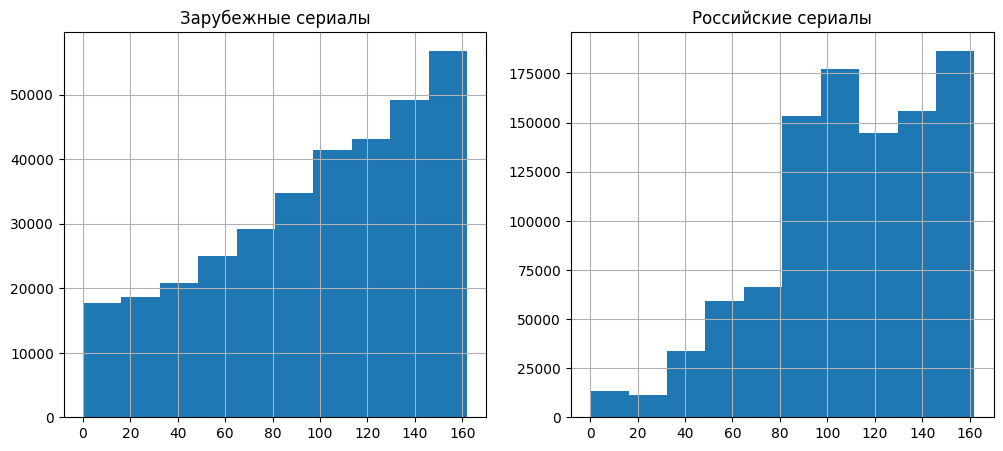

In [ ]:
series_id_not_rus = items.loc[((items.content_type == 'series') & (items.countries != 'Россия'))].item_id.reset_index(drop=True)
series_id_rus = items.loc[((items.content_type == 'series') & (items.countries == 'Россия'))].item_id.reset_index(drop=True)
interactions_not_rus = df.merge(series_id_not_rus, how = 'inner')
interactions_rus = df.merge(series_id_rus, how = 'inner')
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Зарубежные сериалы')
interactions_not_rus.last_watch_dt.hist()
plt.subplot(122)
plt.title('Российские сериалы')
interactions_rus.last_watch_dt.hist()
series_id_not_rus = []
series_id_rus = []
interactions_not_rus = []
interactions_rus = []

**1.** Видим, что в начале периода (март 2021 года) зарубежные сериалы смотрели больше, однако резко российские сериалы обгоняют по популярности их. Скорее всего это связано с выходом новых инетересующих зрителя сериалов, в которых была отражена современная действительность (ковидный период) именно в нашей стране. Так же видим у российских сериалов просадку летом, скорее всего до и после этой просадки выходили высокорейтинговые сериалы

<Axes: >

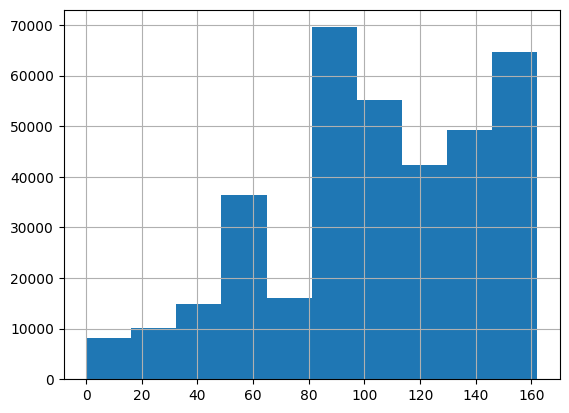

In [ ]:
genres_id = items.loc[(items.genres.str.contains('военные'))].item_id.reset_index(drop=True)
interactions = df.merge(genres_id, how = 'inner')
interactions.last_watch_dt.hist()

**2.** Построили просмотры военных фильмов: видим в районе 60 дней резкий скачок - увеличение популярности во время празднования Дня Победы в мае

   item_id            title
0    15297  Клиника счастья
1    10440      Хрустальный


<Axes: title={'center': 'Хрустальный'}>

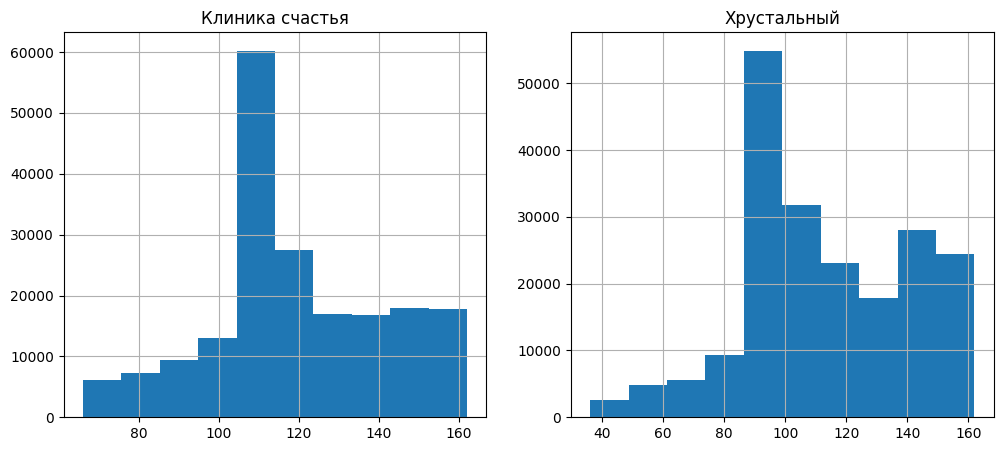

In [ ]:
name = items.loc[(items.item_id==popular_items[0]) | (items.item_id==popular_items[1])][['item_id', 'title']].reset_index(drop=True)
print(name)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title(name.title[0])
interactions_0 = df.loc[df.item_id==name.item_id[0]].copy()
interactions_0.last_watch_dt.hist()
plt.subplot(122)
plt.title(name.title[1])
interactions_1 = df.loc[df.item_id==name.item_id[1]].copy()
interactions_1.last_watch_dt.hist()

**3.** Выводим два самых популярных айтема. Видим, что это как раз оригинальные продукты **Kion**. Тоесть сервис явно активно рекомендовал юзерам свои оригинальные продукты, что видно и из графиков: резкий скачок просмотров и затем резкий спад. Из интерсеных особенностей: Хрустальный судя по всему вышел раньше, кроме того мы знаем, что сервис, начиная со своего запуска активно наращивал аудиторию. Рост аудитории виден из большего покрытия в пике для Клиники счастья.

<Axes: >

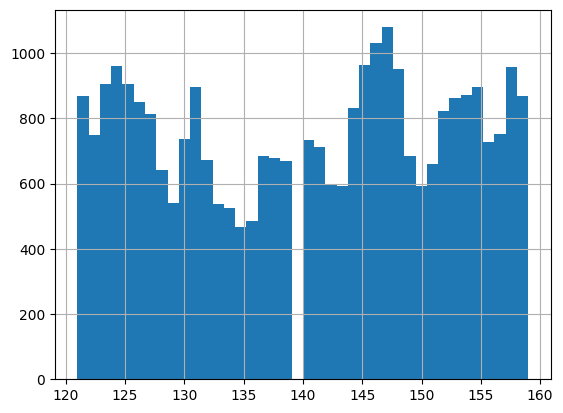

In [ ]:
id = items.loc[(items.title == 'Фемида видит')].item_id.reset_index(drop=True)
interactions = df.merge(id, how = 'inner')
interactions.loc[(interactions.last_watch_dt > 120) & (interactions.last_watch_dt < 160)].last_watch_dt.hist(bins=40)

**4.** Взял оригинальный сериал от Kion "Фемида видит". Он начал выходить летом 2021 года. Здесь в просмотрах хорошо наблюдается сезонность: каждую неделю просмотры имеют локальные максимумы.

<Axes: >

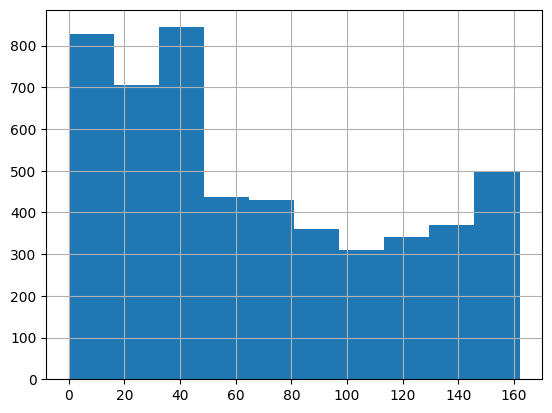

In [ ]:
kids_id = items.loc[((items.for_kids == 1))].item_id.reset_index(drop=True)
interactions = df.merge(kids_id, how = 'inner')
interactions.last_watch_dt.hist()

**5.** Видим просадку просмотров детского контента в летний период. Это объясняется тем, что родители чаще включают детям подобный контент, когда те ходят в детский сад или школу. А в летний период дети больше времени проводят на улице, либо отправляются за город/в лагеря. Дополнительным подтверждением этому служит небольшая просадка в период весенних каникул у школьниковю

**Задание №5. User-item encoding**

Теперь создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить sparse matrix, в которой в качестве строк будут пользователи, в качестве колонок айтемы. Не забудьте закодировать пользователей и айтемы к "внутренней кодировке". В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас второе условие на минимальное число интеракций с айтемом перестанет выполняться. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это может нарушить снова условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока в обоих колонках не будет выполняться требование

In [ ]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and lest popular items.
    Should return copy of the dataframe with at least min_freq entries
    in both users and items
    """
    counts = df.value_counts()
    save_id = counts[counts >= min_freq].index.tolist()
    return save_id

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Should return copy
    of the dataframe
    """
    prev = np.zeros(len(cols))
    cur = np.zeros(len(cols))
    df = df.copy()
    for i, col in enumerate(cols):
      prev[i] = len(df[col])
      df = df.loc[df[col].isin(filter_column(df[col], min_freq))]
      cur[i] = len(df[col])
    while((cur - prev).any()):
      for i, col in enumerate(cols):
        prev[i] = len(df[col])
        df = df.loc[df[col].isin(filter_column(df[col], min_freq))]
        cur[i] = len(df[col])
    return df

print(len(df.item_id))
filtered_train = filter_dataframe(df, ['user_id', 'item_id'], 5)
print(len(filtered_train.item_id))

5476250
4278492


In [ ]:
filtered_train.user_id.value_counts().min()

5

In [ ]:
item2id = {k:v for v, k in enumerate(df.item_id.unique())}
user2id = {k:v for v, k in enumerate(df.user_id.unique())}

id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

lengths = []
lengths.append(len(user2id))
lengths.append(len(item2id))
print(lengths)

def df_encode(df):
  df['user_id'] = df.user_id.apply(lambda x: user2id[x])
  df['item_id'] = df.item_id.apply(lambda x: item2id[x])
  return df


filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

[962179, 15706]


,user_id,item_id,last_watch_dt,total_dur,watched_pct
3616485,111278,6485,47,23,0.0
2074693,161757,235,155,1681,26.0
1765632,63064,113,105,789,12.0
680492,353340,10,110,7636,100.0
730121,57455,418,85,50,0.0


In [ ]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(lengths[0], lengths[1]),
)
matrix

<962179x15706 sparse matrix of type '<class 'numpy.float64'>'
	with 4278492 stored elements in COOrdinate format>

**Задание №6. Интерации и частота**

Нужно построить график на число айтемов и юзеров, которые остаются в матрице интеракций в зависимости от строгости фильтров на встречаемость. То есть нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра

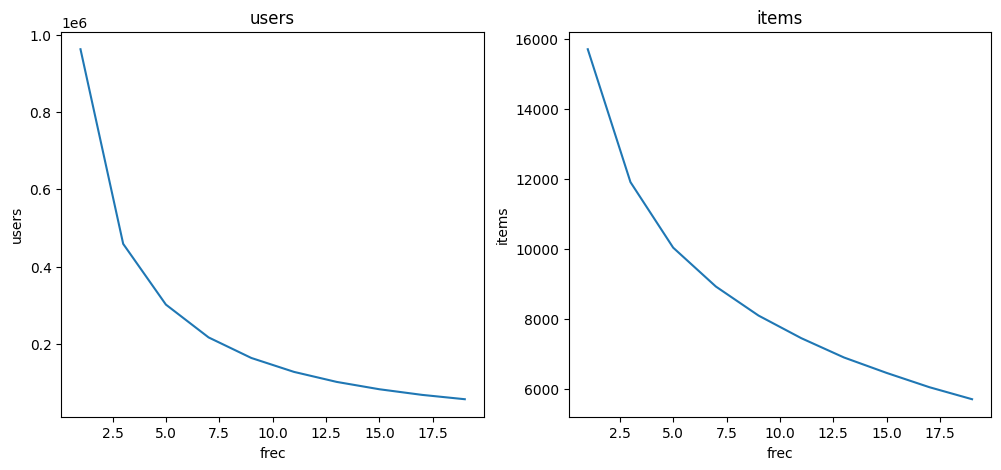

In [ ]:
frecs = c
users = []
items = []

for frec in frecs:
  filtered_train = filter_dataframe(df, ['user_id', 'item_id'], frec)
  users.append(len(filtered_train.user_id.unique()))
  items.append(len(filtered_train.item_id.unique()))

all = [users, items]
names = ["users", "items"]
plt.figure(figsize=(12,5))
for i, name in enumerate(names):
  plt.subplot(121+i)
  plt.title(name)
  plt.plot(frecs, all[i])
  plt.xlabel("frec")
  plt.ylabel(name)
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все метрики качества с `TopPopular` для некоторого набора k

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole

In [ ]:
%%time


def fit_ease(X, reg_weight=1000):

    G = X.T.__mul__(X)
    diags = G.diagonal() + reg_weight*np.ones(G.shape[0])
    G.setdiag(diags)
    P = np.linalg.inv(np.matrix(G.toarray()))
    B = P / -(np.diag(P))
    diag_indices = np.diag_indices(B.shape[0])
    B[diag_indices] = 0

    return B

w = fit_ease(matrix)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 9min 1s, sys: 9.65 s, total: 9min 10s
Wall time: 5min 35s


Далее вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя, и умножить его на матрицу весов

In [ ]:
def get_preds(x, item2id, id2item, topn=100):

    item_id = list(map(lambda i: item2id[i[0]], x))
    u = np.zeros(lengths[1])
    u[item_id] = 1
    preds = np.array(u.dot(w))[0]
    decoded = {id2item[i]:w for i, w in enumerate(preds)}
    decoded = sorted(decoded.items(), key = lambda x: x[1], reverse = True)
    decoded = [x[0] for x in decoded][:topn]
    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,ease_preds
0,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[13865, 10440, 9728, 3734, 10772, 8636, 6809, ..."
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 9728, 13865, 12995, 3734, 7102, 4151, ..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 13865, 9996, 3734, 512, 1..."
3,522,"[(12501, 14), (2424, 15), (12254, 15), (6222, ...","[(11756, 155), (4201, 159), (11899, 159), (107...","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 4151, 9728, 10440, 4880, 1844, 6253, 3..."
4,552,"[(10440, 147)]","[(14703, 158)]","[6259, 9287, 14491]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 13865, 9728, 2657, 9996, 142, 4151, 12..."


In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.07550767216264263, 'mrr': 0.12762041535709365, 'hr': 0.5631}

In [ ]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.090940148540492, 'mrr': 0.15177619755974087, 'hr': 0.6882}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**Как видно, EASE с параметром регуляризации 1000 работает лучше по всем 3 метрикам (результат получен для top-K = 100)

**Задание №8. Тюнинг**

Теперь проварьируйте параметр регуляризации у EASE и постройте все те же графики, что и в задании №6, только путем варирования различных значениях гиперпараметра коэффициента регуляризации. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации

In [ ]:
#your code here

Ответьте на следующие вопросы:

Какое значение гиперпараметра является наилучшим? \\
**Ответ:**

Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга? \
**Ответ:**

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым встречаемости user/item (из задания №6). Сделайте выводы

Важно, в этом задании линии могут быть мало разлимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали отличимыми

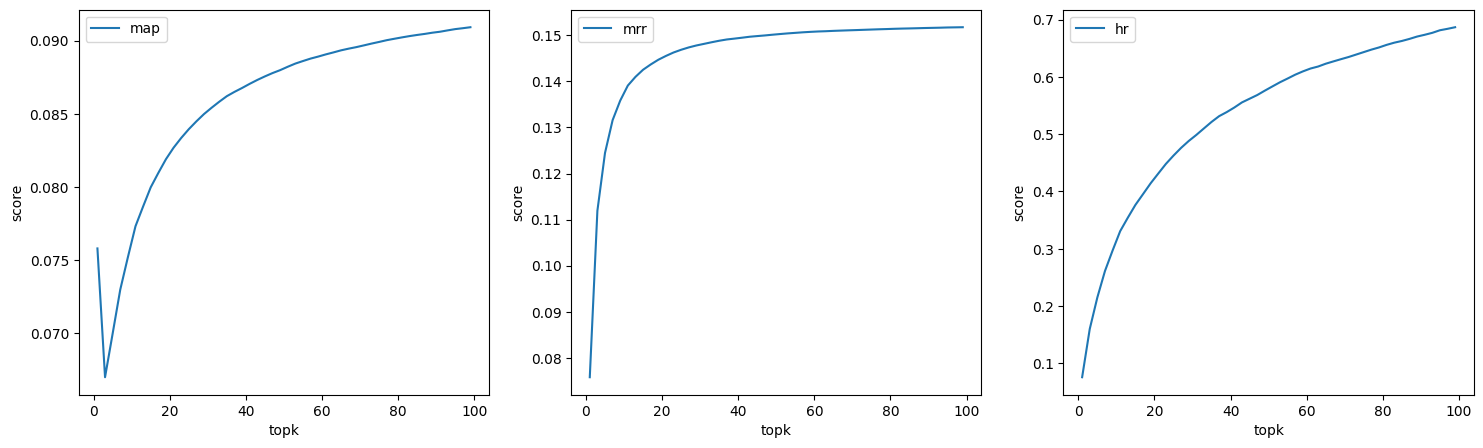

In [ ]:
topk = np.arange(1, 100, 2)
y = []
for n in topk:
  joined['ease_preds_topk'] = joined['ease_preds'].apply(lambda x: x[:n])
  y.append([res[1] for res in evaluate_recommender(joined, model_preds='ease_preds_topk').items()])
y = np.array(y)

names = ["map", "mrr", "hr"]
plt.figure(figsize=(18,5))
for i, name in enumerate(names):
  plt.subplot(131+i)
  plt.plot(topk, y[:, i], label = name)
  plt.xlabel("topk")
  plt.ylabel("score")
  plt.legend()
plt.show()

Что вы можете сказать по графикам? Соответствуют ли они вашим ожиданиям?

**Ответ:**Графики ведут себя примерно так же, как и у алгоритма TopPopular в зависимости от top-K. Однако есть неожиданная просадка у метрики map в самом начале

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов

In [ ]:
sampled_id = np.random.choice(w.shape[0], size = 10).tolist()
for id in sampled_id:
  decod = {id2item[i]:w for i, w in enumerate(np.array(w[id, :])[0])}
  decod = sorted(decod.items(), key = lambda x: x[1], reverse = True)
  decod = [x[0] for x in decod][:5]
  names = items.loc[items.item_id.isin(decod)].title.values
  print(f"Для айтема: {items.loc[items.item_id==id2item[id]].title.values[0]} топ-5:\n")
  for name in names:
    print(f"\t {name}\n")


Для айтема: Бодо Бородо: Путешествия топ-5:

	 Афера

	 Бодо Бородо: БОкварь

	 Дуров

	 Смешарики: Азбука безопасности

	 Бодо Бородо: Песенки

Для айтема: Унесенные рейсом топ-5:

	 Девятаев

	 Планета обезьян: Война

	 Холодное сердце

	 Мишель

	 Три богатыря. Ход конем

Для айтема: Безграничный потенциал топ-5:

	 Ноль

	 Выброс

	 Время разлуки

	 Поступь хаоса

	 Мой создатель

Для айтема: Как у Ким топ-5:

	 Девятаев

	 Планета обезьян: Война

	 Холодное сердце

	 Мишель

	 Три богатыря. Ход конем

Для айтема: Врачиха топ-5:

	 Счастливый шанс

	 Дом для двоих

	 Благие намерения

	 Преступление в фокусе

	 Маруся 2. Трудные взрослые

Для айтема: Отель «Мэриголд»: Лучший из экзотических топ-5:

	 Простые сложности

	 В гостях у Элис

	 Невероятная жизнь Уолтера Митти

	 Спасти мистера Бэнкса

	 Книжный клуб

Для айтема: Индейцы ленка из Гондураса топ-5:

	 Девятаев

	 Планета обезьян: Война

	 Холодное сердце

	 Мишель

	 Три богатыря. Ход конем

Для айтема: 14+ топ-5:

	 Пара 

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** Хорошие рекомендации явно есть, например для самого первого айтема в рекомендациях есть другая часть этого же фильма.\
Плохие примеры тоже есть. Это связано с тем, что некоторые редкие айтемы мы не учитывали, для вся строка в матрице скорее всего состоит из нулей. Для таких фильмов в рекомендации попадают те айтемы, id которых являются первыми столбцами матрицы item2item.